# How to use the RNN Autoencoder with NILMTK

This is an example on how to train and use the Recurrent Network (RNN) disaggregator on the [REDD](http://redd.csail.mit.edu/) dataset using [NILMTK](https://github.com/nilmtk/NILMTK/).

This network was described in the [Neural NILM](https://arxiv.org/pdf/1507.06594.pdf) paper.

First of all, we need to train the RNNDisaggregator using the train data. For this example, both train and test data are consumption data of the microwave of the first REDD building.

In [1]:
import warnings; warnings.simplefilter('ignore')

from nilmtk import DataSet
train = DataSet('redd.h5')
train.set_window(end="30-4-2011") #Use data only until 4/30/2011
train_elec = train.buildings[1].elec

Next, we need to define the disaggregator model.

In [2]:
from grudisaggregator import GRUDisaggregator
gru = GRUDisaggregator()

Using TensorFlow backend.


Then train the model. We need to input the train data as well as their sample period. Also, we need to pass the desired number of training epochs. Finally, save the model for later use.

In [3]:
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['microwave'] # The microwave meter that is used as a training target

gru.train(train_mains, train_meter, epochs=5, sample_period=1)
gru.export_model("model-redd5.h5")

Epoch 1/5
1003066/1003066 [==============================] - 137s - loss: 7.2744e-04   
Epoch 2/5
1003066/1003066 [==============================] - 105s - loss: 6.6916e-04   
Epoch 3/5
1003066/1003066 [==============================] - 106s - loss: 6.5737e-04   
Epoch 4/5
1003066/1003066 [==============================] - 106s - loss: 6.5401e-04   
Epoch 5/5
1003066/1003066 [==============================] - 103s - loss: 6.5021e-04   


Now that the model is trained, we can use it to disaggregate energy data. Let's test it on the rest of the data from building 1.

First we use the model to predict the microwave consumption. The results are saved automatically in a .h5 datastore.

In [4]:
test = DataSet('redd.h5')
test.set_window(start="30-4-2011")
test_elec = test.buildings[1].elec
test_mains = test_elec.mains().all_meters()[0]

disag_filename = 'disag-out.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
gru.disaggregate(test_mains, output, train_meter, sample_period=1)

New sensible chunk: 121482
New sensible chunk: 112661
New sensible chunk: 87770
New sensible chunk: 54084
New sensible chunk: 2660
New sensible chunk: 33513
New sensible chunk: 138535
New sensible chunk: 32514
New sensible chunk: 27255
New sensible chunk: 34833
New sensible chunk: 100831


Let's plot the results and compare them to the ground truth signal.

**Note:** Calling plot this way, downsamples the signal to reduce computing time. To plot the entire signal call
```
predicted.power_series_all_data().plot()
ground_truth.power_series_all_data().plot()
```

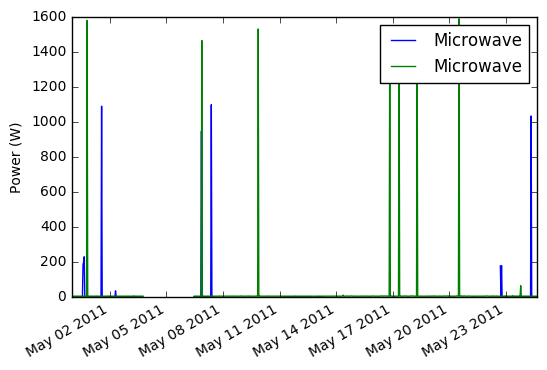

In [5]:
result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['microwave']
ground_truth = test_elec['microwave']

import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
plt.show()

Finally let's see the metric results.

In [6]:
import metrics
rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

============ Recall: 0.0370807004875
============ Precision: 0.813554622514
============ Accuracy: 0.278783362107
============ F1 Score: 0.0709285741419
============ Relative error in total energy: 0.768754882991
============ Mean absolute error(in Watts): 19.2988829522
